# Functional flows and HMF availability

In [3]:
# Import packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import dataretrieval.nwis as nwis # for downloading observed streamflow data from USGS
from matplotlib.dates import MonthLocator, DateFormatter # for plotting month on x-axis

In [4]:
# Conversions
MAF_to_km3 = 1e6 * 43560 * 0.0283 * 1e-9
km3_to_MAF = 1 / (1e6 * 43560 * 0.0283 * 1e-9)
cfs_to_maf = 60 * 60 * 24 / 43560 / 1e6
cfs_to_km3 = 60 * 60 * 24 * 0.0283 * 1e-9

In [5]:
# Functions
# Download observed daily streamflow (USGS)
def download_usgs_flow(site_id, start_date, end_date):
    df = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
    return df

def add_WY_DOHY_month(df):
    df['datetime'] = pd.to_datetime(df.index)
    df['month'] = df['datetime'].dt.strftime('%m') # create month column
    df['year'] = df['datetime'].dt.strftime('%Y') # create year column 
    df['WY'] = np.where((df['month'] == '10') | (df['month'] == '11') | (df['month'] == '12'), df['year'].astype(int) + 1, df['year'].astype(int)) # create WY column where the WY resets in Oct
    df['WY'] = df['WY'].values.astype(str)
    df['DOY'] = df['datetime'].dt.dayofyear # create column with DOY
    df['DOHY'] = [d - 273 if d >= 274 else d + 91 for d in df['DOY']]
    df['datetime'] = df['datetime'].dt.date # reset index to date only (no time)
    df.set_index('datetime', inplace=True)
    columns_to_remove = ['year']
    #df = df.drop(columns=columns_to_remove)
    return df

def plot_single_year(df, year):
    df = df.reset_index()
    df['datetime']= pd.to_datetime(df['datetime'])
    #df['datetime'] = pd.to_datetime(df.index)
    PLOT_START = str(year)+'-10-01'
    next_year = year+1
    PLOT_END = str(next_year)+'-10-01'
    df_plot = df.loc[(df['datetime'] >= PLOT_START) & (df['datetime'] <= PLOT_END)]
    #ax.plot(df_plot['flow_cfs'], label=flow_type)
    return df_plot

def download_func_flows(link):
    df = pd.read_csv(link)
    df['date']= pd.to_datetime(df['date'])
    df = df.dropna()
    df = df.rename(columns={'date': 'datetime', 'flow': 'flow_cfs'})
    df.set_index('datetime', inplace=True)
    df = add_WY_DOHY_month(df)
    return df

def flow_selection_based_on_month_set0(df):
    selected_flow = []
    ferc_month = ['07', '08', '09', '10', '11', '12', '01']
    #fnf_month = ['02', '03', '04', '05', '06']
    for index, row in df.iterrows():
        if row['month'] in ferc_month:
            selected_flow.append(0)
        else:
            selected_flow.append(row['flow_cfs'])
    df['flow_cfs'] = selected_flow
    selected_columns = ['flow_cfs']
    df = df[selected_columns]
    return df

def calc_threshold(df, percentile):
    return round(df['flow_cfs'].quantile(percentile), 1)

In [6]:
# Download observed flows
sites = [11289650, 11290000]
name = ['tlg', 'mod']

start_year = '1994'
start_date = start_year+'-10-01' # '1929-10-01'
#end_date = '2015-04-28' # ending date for Kocis paper
end_date = '2023-09-30' # include most recent 30-year record

df_tlg = download_usgs_flow(11289650, start_date, end_date)
df_tlg = add_WY_DOHY_month(df_tlg)

df_mod = download_usgs_flow(11290000, start_date, end_date)
df_mod = add_WY_DOHY_month(df_mod)

In [7]:
# Download functional flows
ff = download_func_flows('../data_clean/perfectforesight_FFAIM_Extended.csv')

In [8]:
# Select ff data for same years as UF
idx_list = list(range(1994, 2024))
idx_str = [str(value) for value in idx_list]
ff = ff[ff['WY'].isin(idx_str)]
ff_annual = ff.groupby('WY')['flow_cfs'].sum() * cfs_to_maf # MAF

In [9]:
# 40% Unimpaired flows with FERC at TLG
%run unimp_ferc_flow_construction.ipynb
uf40_11289650 = add_WY_DOHY_month(uf_ferc_11289650)
#flowDict['uf_ferc_11289650'] = uf_ferc_11289650
#uf40_11289650 = flow_selection_based_on_month_set0(uf_ferc_11289650)
#uf40_11289650 = add_WY_DOHY_month(uf40_11289650)

uf40_tlg_annual = uf40_11289650.groupby('WY')['flow_cfs'].sum() * cfs_to_maf # MAF

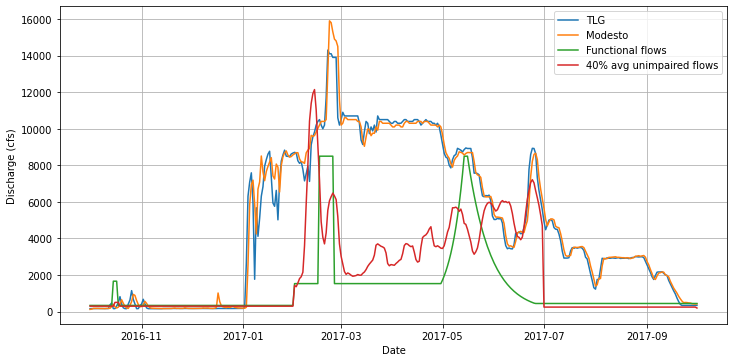

In [10]:
# Plot timeseries
year = 2016

plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(1,1, figsize=(10,5))
fig.tight_layout()

df_tlg_plot = plot_single_year(df_tlg, year)
df_mod_plot = plot_single_year(df_mod, year)
ff_plot = plot_single_year(ff, year)
uf_plot = plot_single_year(uf40_11289650, year)

ax.plot(df_tlg_plot['datetime'], df_tlg_plot['flow_cfs'], label='TLG')
ax.plot(df_mod_plot['datetime'], df_mod_plot['flow_cfs'], label='Modesto')
ax.plot(ff_plot['datetime'], ff_plot['flow_cfs'], label='Functional flows')
ax.plot(uf_plot['datetime'], uf_plot['flow_cfs'], label='40% avg unimpaired flows')

ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cfs)')

plt.legend()

plt.show()

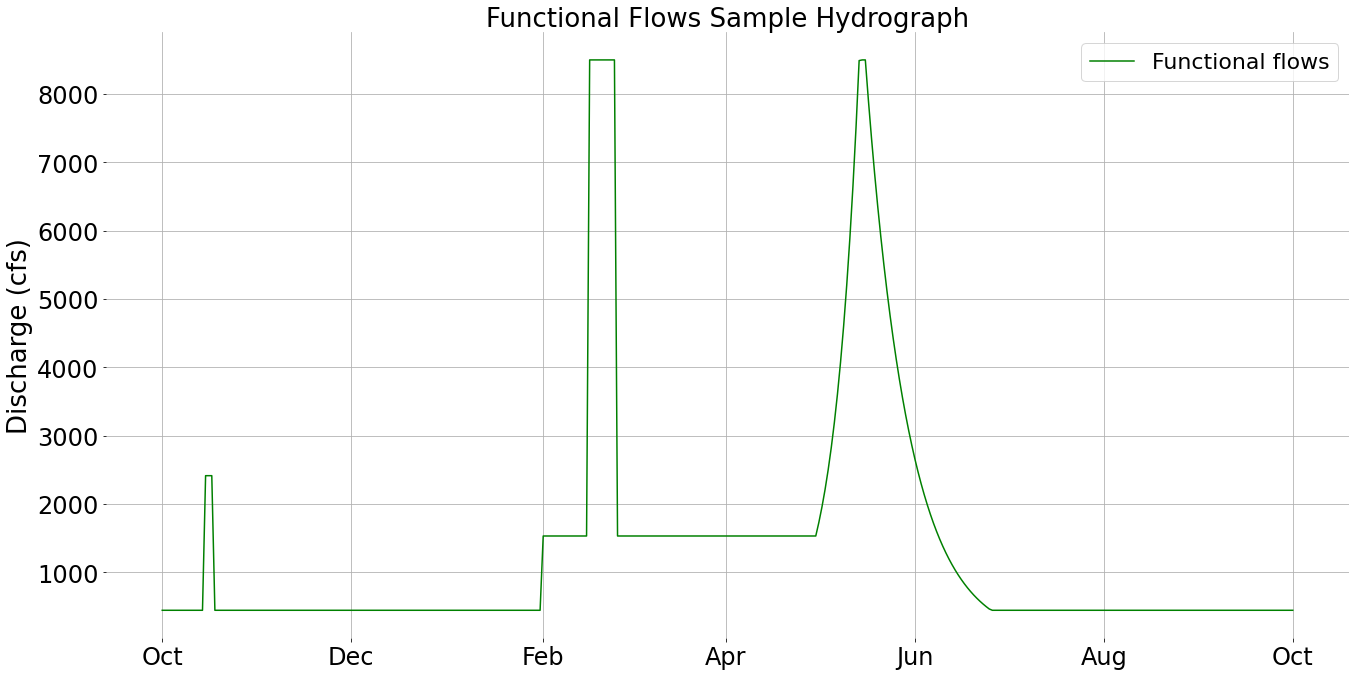

In [18]:
# Sample functional flows figure for poster
year = 2005

plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(1,1, figsize=(18,9))
fig.tight_layout()

df_tlg_plot = plot_single_year(df_tlg, year)
df_mod_plot = plot_single_year(df_mod, year)
ff_plot = plot_single_year(ff, year)
uf_plot = plot_single_year(uf40_11289650, year)

#ax.plot(df_tlg_plot['datetime'], df_tlg_plot['flow_cfs'], label='TLG')
#ax.plot(df_mod_plot['datetime'], df_mod_plot['flow_cfs'], label='Modesto')
ax.plot(ff_plot['datetime'], ff_plot['flow_cfs'], color='green', label='Functional flows')
#ax.plot(uf_plot['datetime'], uf_plot['flow_cfs'], label='40% avg unimpaired flows')

plt.gca().xaxis.set_major_locator(MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))  # %b for month abbreviation

#ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Discharge (cfs)', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_title('Functional Flows Sample Hydrograph', fontsize=26)

# Remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.legend(fontsize=22)

file_name = 'C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\results\\figures\\timeseries\\streamflow\\Tuol\\tuol_func_flows_sample.png'
plt.savefig(file_name, bbox_inches="tight")

plt.show()

In [2]:
# Create categories for the x-axis
categories = uf40_11289650['WY'].unique()

# Create bar plot
x = np.arange(len(categories)) # Create an array of x positions for the bars

# Set bar width
width = 0.25  # Width of the bars

# Initialize figure
fig, ax = plt.subplots(figsize=(20,5))

bar1 = ax.bar(x - width/2, ff_annual, width, color='C0', label='Functional Flows')
bar2 = ax.bar(x + width/2, uf40_tlg_annual, width, color='seagreen', label='40% Unimpaired Flows')

ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, fontsize=14)

plt.legend()

plt.show()

NameError: name 'uf40_11289650' is not defined